In [ ]:
## This is for gate-based folding

In [1]:
## Overall error mitigation parameters
numqubits = 3


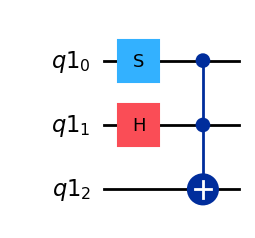

In [35]:
## Step 1: Create your original circuit. 

import qiskit
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import Estimator
from qiskit import transpile
from qiskit.visualization import plot_distribution
import numpy as np
import matplotlib.pyplot as plt

q0 = QuantumRegister(numqubits, name = 'q0')
qc0 = QuantumCircuit(q0, name = 'qc0') # exists solely to add barriers. 

qc0.barrier()

q1 = QuantumRegister(numqubits, name='q1')
qc1 = QuantumCircuit(q1, name = 'qc1')

qc1.s(0)
qc1.h(1)
qc1.ccx(0,1,2)
#qc1.cx(0,2)

qc1.draw('mpl')


In [3]:
## Step 2: Decompose the original circuit into layers

## Decompose the original circuit into layers
dag = circuit_to_dag(qc1)

# Create a reversed version of the original circuit
temp = reversed(list(dag.layers()))

### Create a blank quantum circuit that will store the inverted version of the original circuit
#q2 = QuantumRegister(numqubits, name='q2')
#qc2 = QuantumCircuit(q2, name = 'qc2')
#
## Iterate through the reversed circuit
## to insert the original circuit into the new circuit
#for temp2 in temp:
#    
#    layer_as_circuit = dag_to_circuit(temp2['graph']).inverse()
#    qc2 = qc2.compose(layer_as_circuit, [0,1,2])
#
#qc2.draw('mpl')

In [4]:
temp = dag.layers()
hah = list(temp)
for temp2 in hah:
    print(dag_to_circuit(temp2['graph']))

      ┌───┐
q1_0: ┤ S ├
      ├───┤
q1_1: ┤ H ├
      └───┘
q1_2: ─────
           
           
q1_0: ──■──
        │  
q1_1: ──■──
      ┌─┴─┐
q1_2: ┤ X ├
      └───┘


In [6]:
def generate_gate_folded_circuit(lambda_value,original_circuit, final_circuit, barrier_circuit):

    if not(isinstance(lambda_value, int)):
        print("Lambda_value is not an integer. Please enter an integer. ")
        return final_circuit;
    if not(lambda_value % 2):
        print("Lambda_value is not an odd integer. Please enter an odd integer. ")
        return final_circuit;
    if lambda_value == 1:
        final_circuit = original_circuit.copy() # The "folded" circuit is just the original.
        final_circuit.measure_all(); # We assume that the final_circuit object is empty. 
        return final_circuit;
    print("OK value of lambda")
    
    ## Decompose the original circuit into layers
    dag = circuit_to_dag(original_circuit)
    numlayers = len(list(dag.layers())) # Number of layers in the original circuit
    temp = list(dag.layers())
    
    for temp2 in temp:
        ## Insert the original layer, then insert (lambda-1)/2 inverse-original pairs of that layer
        layer_as_circuit_original = dag_to_circuit(temp2['graph']) # The original layer
        
        layer_as_circuit_inverse = dag_to_circuit(temp2['graph']).inverse() # The inverse of that layer

        # Insert the original layer. 
        final_circuit = final_circuit.compose(layer_as_circuit_original)

        # Insert (lambda-1)/2 inverse-original pairs of that layer
        for index in range(round((lambda_value-1)/2)):
            final_circuit = final_circuit.compose(layer_as_circuit_inverse)
            final_circuit = final_circuit.compose(layer_as_circuit_original)
            
    
    final_circuit.measure_all()
    return final_circuit;

OK value of lambda


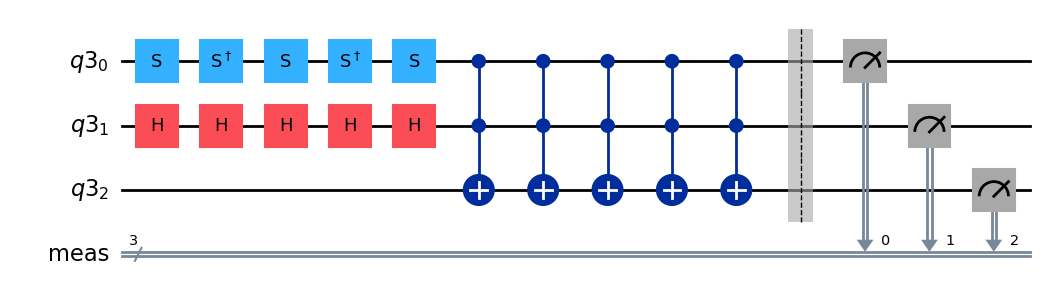

In [28]:
q3 = QuantumRegister(numqubits, name='q3')
qc3 = QuantumCircuit(q3, name = 'qc3')
qc3 = generate_gate_folded_circuit(5, qc1, qc3, qc0)
qc3.draw('mpl')

In [8]:
q_ideal = QuantumRegister(numqubits, name = 'q_ideal')
qc_ideal = QuantumCircuit(q_ideal, name = 'q_ideal')
qc_ideal = qc1.copy()
qc_ideal.measure_all()
print(qc_ideal)
print(qc1)

        ┌───┐      ░ ┌─┐      
  q1_0: ┤ S ├──■───░─┤M├──────
        ├───┤  │   ░ └╥┘┌─┐   
  q1_1: ┤ H ├──■───░──╫─┤M├───
        └───┘┌─┴─┐ ░  ║ └╥┘┌─┐
  q1_2: ─────┤ X ├─░──╫──╫─┤M├
             └───┘ ░  ║  ║ └╥┘
meas: 3/══════════════╩══╩══╩═
                      0  1  2 
      ┌───┐     
q1_0: ┤ S ├──■──
      ├───┤  │  
q1_1: ┤ H ├──■──
      └───┘┌─┴─┐
q1_2: ─────┤ X ├
           └───┘


In [21]:
## Overall simulation parameters
numshots = 10000
target_value = ""
for index in range(numqubits):
    target_value += "0"
print(target_value)

000


In [26]:
# Construct an ideal simulator
sim_ideal = AerSimulator(method='density_matrix')


# Perform an ideal simulation
result = sim_ideal.run(transpile(qc_ideal, sim_ideal), shots = numshots).result()
counts = result.get_counts(0)
plot_distribution(counts, title='Ideal counts for my circuit')

ideal_val = result.get_counts(0)[target_value]
print(ideal_val/numshots)

0.4967


In [27]:
## Create a simple depolarising noise model
# All gates suffer from depolarising noise uniformly
noise_model = NoiseModel()

depolarising_prob = 0.1;

# Add depolarizing error to all single qubit gates
error = depolarizing_error(depolarising_prob, 1)
cx_error = depolarizing_error(depolarising_prob, 2) # CNOT errors
ccx_error = depolarizing_error(depolarising_prob, 3) # CCNOT errors

noise_model.add_all_qubit_quantum_error(
    error, ["h"]
)
noise_model.add_all_qubit_quantum_error(
    error, ["z"]
)
noise_model.add_all_qubit_quantum_error(
    error, ["s"]
)
noise_model.add_all_qubit_quantum_error(
    cx_error, ["cx"]
)
noise_model.add_all_qubit_quantum_error(
    ccx_error, ["ccx"]
)

In [ ]:
# Perform a noisy simulation
sim_noisy = AerSimulator(noise_model=noise_model, method='density_matrix')

result = sim_noisy.run(transpile(qc3, sim_noisy), shots = numshots).result()
counts = result.get_counts(0)
plot_distribution(counts, title='Noisy counts for my circuit')
noisy_val = result.get_counts(0)[target_value]
print(noisy_val/numshots)

In [37]:
## Perform a series of at least 2 noisy simulations. 
lambda_value_array = [1, 3,5, 7];
measured_values_array = [];
#measured_values_array.append(ideal_val/numshots)


for value in lambda_value_array:
    q3 = QuantumRegister(numqubits, name='q3')
    qc3 = QuantumCircuit(q3, name = 'qc3')
    qc3 = generate_gate_folded_circuit(value, qc1, qc3, qc0)
    
    # Perform a noisy simulation
    sim_noisy = AerSimulator(noise_model=noise_model, method='density_matrix')
    
    result = sim_noisy.run(transpile(qc3, sim_noisy), shots = numshots).result()
    counts = result.get_counts(0)
    #plot_distribution(counts, title='Noisy counts for my circuit')
    noisy_val = result.get_counts(0)[target_value]
    print(noisy_val/numshots)
    measured_values_array.append(noisy_val/numshots)
    

0.4426
OK value of lambda
0.3791
OK value of lambda
0.3404
OK value of lambda
0.2925


In [31]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a + b * np.exp(-c * x)
    

In [38]:
## Data processing part

lambda_vals_tot = np.array(lambda_value_array)
measured_vals_tot = np.array(measured_values_array)

# Interrogation domain
xp = np.linspace(0,np.amax(lambda_vals_tot),100)

# Polynomial fit
linfit = np.polyfit(lambda_vals_tot, measured_vals_tot, 1)
p_p = np.poly1d(linfit)
error_mitigated_value_polynomial = p_p(0)

# Richardson extrapolation fit
REfit = np.polyfit(lambda_vals_tot, measured_vals_tot, len(measured_vals_tot)-1)
p_RE = np.poly1d(REfit)
error_mitigated_value_RE = p_RE(0)

# Exponential fit
popt, pcov = curve_fit(func, lambda_vals_tot, measured_vals_tot)
error_mitigated_value_exp = func(0, *popt)
print(popt)

[0.07642579 0.39750012 0.08581678]


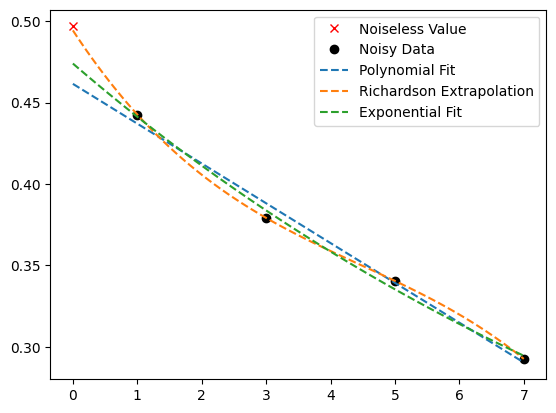

In [39]:

plt.figure()
plt.plot([0], ideal_val/numshots, 'rx', label="Noiseless Value") # Ideal value, without noise. 
plt.plot(lambda_vals_tot, measured_vals_tot, 'ko', label="Noisy Data")
plt.plot(xp, p_p(xp), '--', label="Polynomial Fit")
plt.plot(xp, p_RE(xp), '--', label="Richardson Extrapolation")
plt.plot(xp, func(xp, *popt), '--', label="Exponential Fit") # Exponential fit
plt.legend()

#plt.plot([0],ideal_val/numshots, 'x', lambda_vals_tot, measured_vals_tot, '.', xp, p(xp), '--')